# Intro

Questions: 
* shouldnt i be able to calculate the cumulative return by multiplying all log_returns then using the exponential function to get 1+cumulative return?
 (np.power(np.exp(np.sum(log_rets)),252/2216)-1)
 YearTradingDays = 252
 totalTradingDays = 2216
 1+r_cum = pi/p0 * pi+1/pi * ........
 log(1+r_cum) = log(pi/p0 * pi+1/pi * ........)
          = log(pi/p0) + log(pi+1/pi) + log(..) + .....
1 + r_cum = np.exp(log(pi/p0) + log(pi+1/pi) + log(..) + .....)  
annualized_return = (1+r_cum) ^ (252/2216) - 1

* investors should choose any point on the CML according to their risk tolerance. but how can you do that? the CML gives you the expected return and volatility of a portfolio. Can you extract the weights from this? Arent all the possible options encapsulated within the efficient frontier? so it is actually impossible to be on CML other than the optimal portfolio (tangent between efficient frontier and CML)


In [50]:
import numpy as np  # array operations
import pandas as pd  # time series management
import matplotlib.pyplot as plt  # standard plotting library
#from pylab import plt
plt.style.use('ggplot')
# put all plots in the notebook itself
%matplotlib inline

## 1. Retreiving stock prices

In [51]:
symbols = ['AAPL.O', 'MSFT.O', 'AMZN.O', 'INTC.O']  # our symbols
data = pd.read_csv('https://hilpisch.com/tr_eikon_eod_data.csv', index_col = 0, parse_dates = True) # parse dates changes the type of the index values from pandas.core.indexes.base.Index to pandas.core.indexes.datetimes.DatetimeIndex

data = data[symbols]
data = data.dropna()

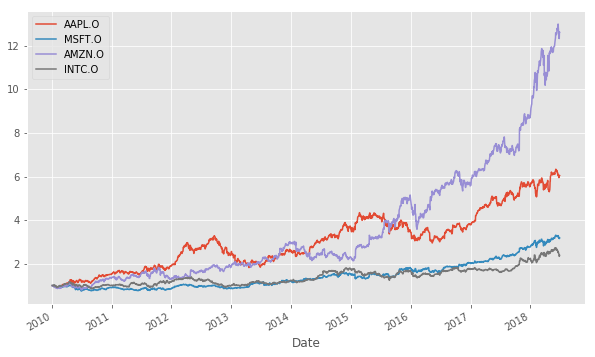

In [52]:
(data / data.iloc[1]).plot(figsize=(10, 6))# shows you how many folds each stock price changed compared to the price at the first data point (2010-01-01)

## 2. Portfolio Returns

The first step is to calculate the annualized returns of the different stocks based on the log returns for the respective time series. I do not understand why Yves Hilpisch descides to simply multiply the average value of the log returns by the number of trading days instead of using the formula (1+cumulative return)^(365/Days Held). I will use his method to be able to compare my results to his. 

In [53]:
tradingDays = 252
log_rets = (np.log(data)).diff()
rets = log_rets.mean() * tradingDays
rets

AAPL.O    0.212359
MSFT.O    0.136648
AMZN.O    0.299661
INTC.O    0.102288
dtype: float64

My preferred method to calculate returns is: 
$ Annualized returns = (1 + Cumulative Returns) ^{(YearTradingDays/TotalTradingDays)} - 1$

In [54]:
np.power(np.exp(np.sum(log_rets)),356/(data.index[-1] - data.index[0]).days)-1

AAPL.O    0.229908
MSFT.O    0.142434
AMZN.O    0.339121
INTC.O    0.104814
dtype: float64

Now we need to assign weights to each asset of our portfolio. We will start with an equal weighting scheme.

In [55]:
weights = np.array(len(symbols)*[1/len(symbols)])
weights

array([0.25, 0.25, 0.25, 0.25])

Portfolio return is the sum of the product of each asset return and its associated weight
$$
\begin{align}
\mu_p &= \mathbf{E} \left( \sum_I w_i r_i \right) \\
        &= \sum_I w_i \mathbf{E}\left( r_i \right) \\
        &= \sum_I w_i \mu_i \\
        &= w^T \mu
\end{align}
$$

Where $w_i$ are the weights for the single portfolio components and the $r_i$ are the respective returns.

In [56]:
np.dot(weights,rets)

0.18773897722428992

## 3. Portfolio Variance

To calculate the portfolio variance, you first need to calculate the covariance matrix

$\begin{align}
\Sigma = \begin{bmatrix}
        \sigma_{1}^2 \ \sigma_{12} \ \dots \ \sigma_{1I} \\
        \sigma_{21} \ \sigma_{2}^2 \ \dots \ \sigma_{2I} \\
        \vdots \ \vdots \ \ddots \ \vdots \\
        \sigma_{I1} \ \sigma_{I2} \ \dots \ \sigma_{I}^2
    \end{bmatrix}
\end{align}$

Each stock's variance is on the diagonal, and the covariance between each stock couple is everywhere else.
Covariance of two assets (two random variables) provides information on whether they have a positive or negative relationship. Covariance does not provide information
on how strong the relationship is. 

In [57]:
cov_matrix  = log_rets.cov() * 252
cov_matrix

,AAPL.O,MSFT.O,AMZN.O,INTC.O
AAPL.O,0.063773,0.023427,0.026994,0.023483
MSFT.O,0.023427,0.050917,0.030208,0.030173
AMZN.O,0.026994,0.030208,0.095462,0.025311
INTC.O,0.023483,0.030173,0.025311,0.056015


Given the covariance matrix $\Sigma$, the portfolio variance is defined as: 
$
\begin{align}
\sigma_p^2 &= \mathbf{E}\left( (r - \mu)^2 \right) \\
        &= \sum_{i \in I}\sum_{j \in I} w_i w_j \sigma_{ij} \\
        &= w^T \Sigma w
\end{align}
$

In [58]:
#portfolio variance
pvar = np.dot(weights.T, np.dot(cov_matrix, weights))
pvar

0.036584969390480115

Portfolio volatilty (standard deviation) is the square root of the portfolio variance.

In [59]:
pvol = pvar ** 0.5
pvol

0.19127197753586414

## 4. Random Portfolio Compositions

Next, let us generate a random portfolio composition and calculate the resulting portfolio return and variance.


In [60]:
weights = np.random.random(len(symbols))
weights /= np.sum(weights)
weights

array([0.15077774, 0.40624654, 0.29069661, 0.15227911])

In [61]:
# portfolio return
np.dot(rets, weights) # portfolio return (random weights)

0.19021862072121348

In [62]:
cov_matrix = log_rets.cov() * 252

In [63]:
# portfolio variance
pvar = np.dot(weights.T, np.dot(cov_matrix, weights))
# portfolio volatility
pvol = pvar ** 0.5

We are now going to implement a Monte Carlo simulation for the portfolio weights and collect the resulting portfolio returns and volatilities.
This means we will choose the weights randomly thousands of times, calculate the returns and volatility of the resulting portfolio for each time and see what distributions we get. 

In [64]:
prets = []
pvols = []
minVarWeights = []
minVar = 10
for p in range(5000):
    weights = np.random.random(len(symbols))
    weights /= np.sum(weights)
    prets.append(np.dot(weights, rets))
    cov_matrix = log_rets.cov() * tradingDays
    pvar = np.dot(weights.T, np.dot(cov_matrix, weights))
    if pvar < minVar:
        minVar = pvar
        minVarWeights = weights
    pvols.append(pvar ** 0.5)
prets = np.array(prets)
pvols = np.array(pvols)
portfolio = pd.DataFrame({"returns": prets, "volatility": pvols})
portfolio.head()

,returns,volatility
0,0.187105,0.190866
1,0.162952,0.188680
2,0.202285,0.202118
3,0.145386,0.198458
4,0.208941,0.201934


The collected results allow for an insightful visualization. We can easily spot the area of the minimum variance portfolio and also see the efficient frontier quite well.
We also have the weights (minVarWeights) that constitue the minimum variance portfolio. It is plotted with a red point in the figure below.



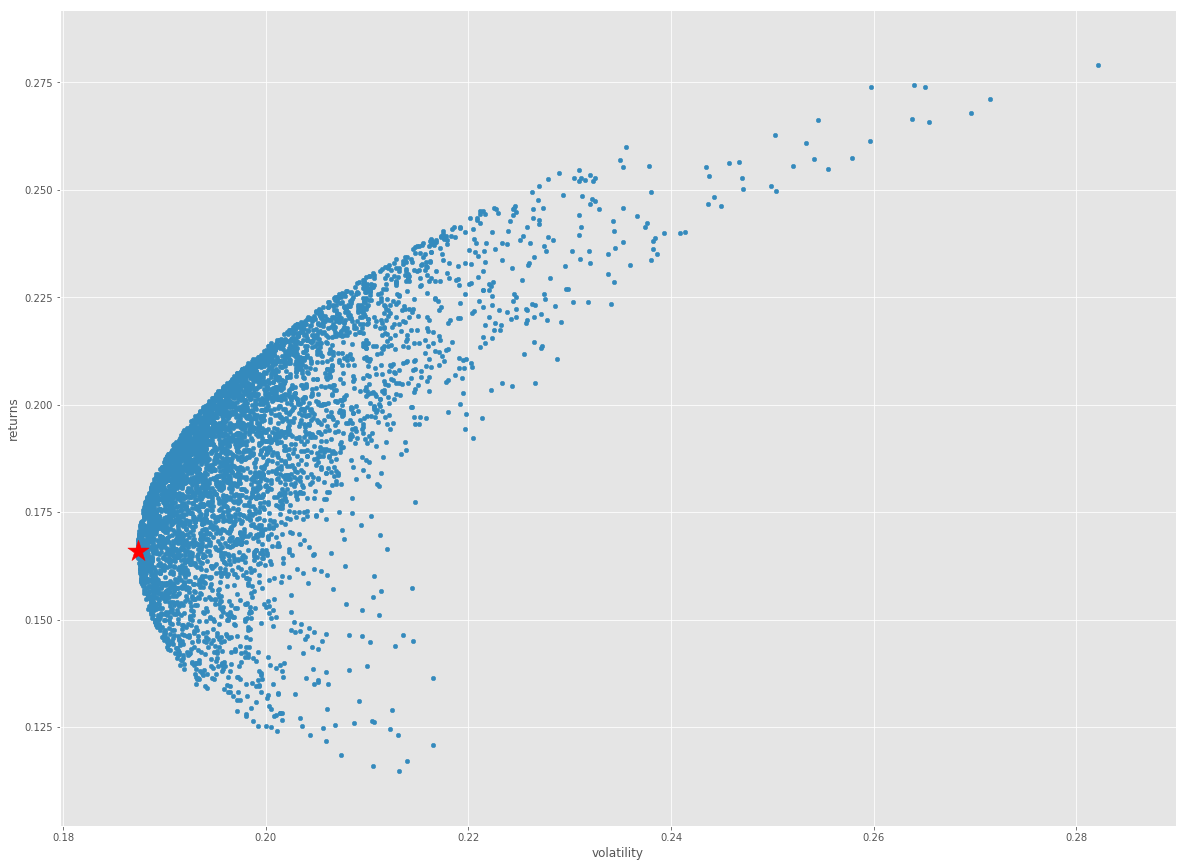

In [65]:
ax = portfolio.plot(x = 'volatility', y = 'returns', kind = 'scatter', figsize = (15,10))
portfolio[portfolio.volatility == portfolio.volatility.min() ].plot(ax = ax, x = 'volatility', y = 'returns', kind = 'scatter', figsize = (20,15), color = 'r', s = 500, marker = '*')

In [66]:
riskFreeReturn = 0.01 
portfolio['sharpe'] = (portfolio.returns - riskFreeReturn)/portfolio.volatility

In [67]:
optPortIndex = portfolio.sharpe.idxmax()
optPort = portfolio.iloc[optPortIndex]

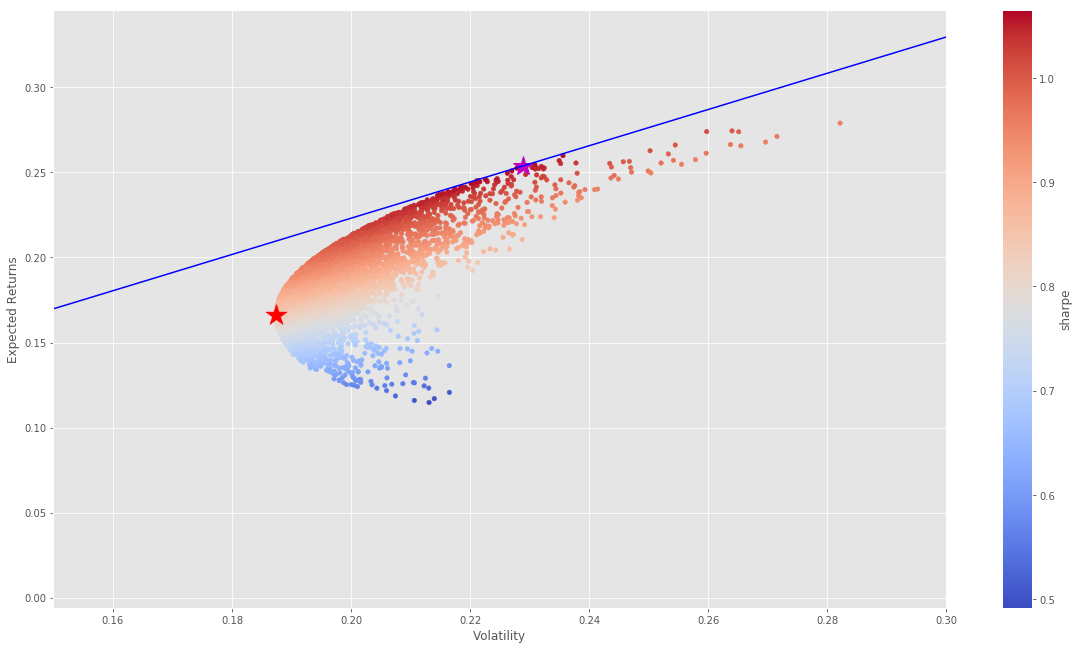

In [68]:
CMLx = [0, optPort.loc['volatility'], 0.3]
CMLy = [riskFreeReturn, optPort.loc['returns'], riskFreeReturn + optPort.loc['sharpe'] * 0.3]
fig, ax = plt.subplots()
portfolio.plot(ax = ax, x = 'volatility', y = 'returns', kind = 'scatter', figsize = (20,11), c = 'sharpe', cmap = 'coolwarm')
#plt.scatter(portfolio[portfolio.volatility == portfolio.volatility.min()]['volatility'],portfolio[portfolio.volatility == portfolio.volatility.min()]['returns'], c = )
portfolio[portfolio.volatility == portfolio.volatility.min()].plot(ax = ax, x = 'volatility', y = 'returns', kind = 'scatter', color = 'r', s = 500, marker = '*')
ax = plt.plot(optPort.loc['volatility'],optPort.loc['returns'],'m*', markersize = 20)
ax = plt.plot(CMLx, CMLy,'b')
plt.ylabel('Expected Returns')
plt.xlabel('Volatility')

plt.xlim([0.15,0.3])
plt.show()


In [69]:
zBar = rets 
S = cov_matrix
Sinv = np. linalg. inv(S)
unitVec = np.ones(len(zBar))
stdevs = np.diag(S) ** 0.5

In [70]:
A = np.dot(unitVec.T,np.dot(Sinv,unitVec))
B = np.dot(unitVec.T, np.dot(Sinv, zBar))
C = np.dot(zBar.T, np.dot(Sinv, zBar))
delta = A*C - np.power(B,2)

In [71]:
mu = np.array(list(range(300)))/100
mu

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49, 1.

In [72]:
variance = (A * np.power(mu,2) - 2 * B * mu + C)/delta
minstd = np.sqrt(variance)

(0.07, 0.3)

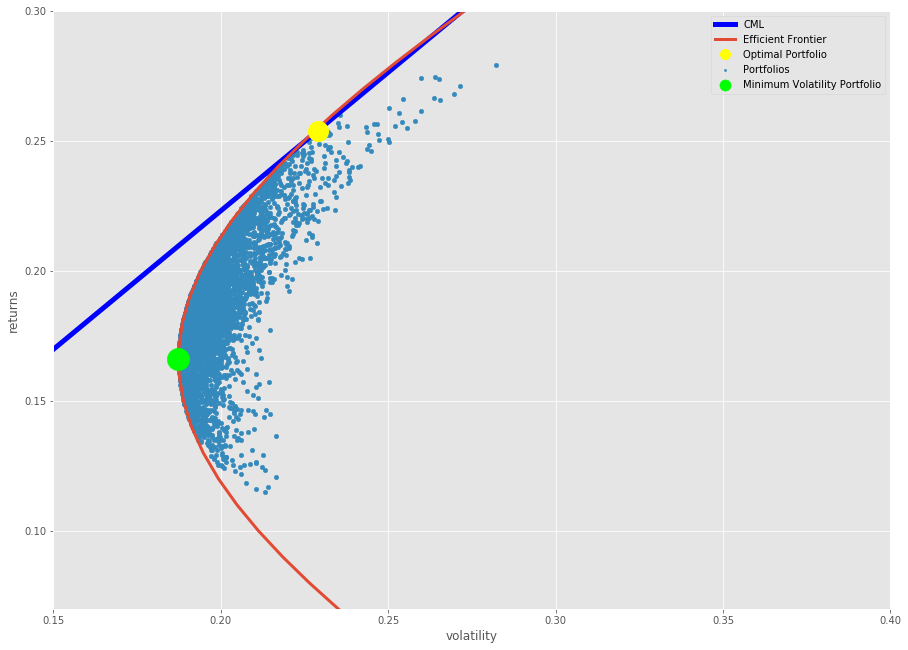

In [73]:
CMLx = [0, optPort.loc['volatility'], 0.3]
CMLy = [riskFreeReturn, optPort.loc['returns'], riskFreeReturn + optPort.loc['sharpe'] * 0.3]

ax = portfolio.plot(x = 'volatility', y = 'returns', kind = 'scatter', figsize = (15,11), label = 'Portfolios')
plt.plot(CMLx, CMLy,'b', linewidth = 5, label = 'CML')
plt.plot(minstd,mu, linewidth = 3, label = 'Efficient Frontier')
plt.plot(optPort.loc['volatility'],optPort.loc['returns'],'o', color = 'yellow', markersize = 20, label = 'Optimal Portfolio')
portfolio[portfolio.volatility == portfolio.volatility.min() ].plot(ax = ax, x = 'volatility', y = 'returns', kind = 'scatter', marker = 'o', figsize = (15,11), color = 'lime', s = 500, zorder = 10, label = 'Minimum Volatility Portfolio')
lgnd = plt.legend(markerscale = 0.5)
plt.xlim([0.15,0.4])
plt.ylim([0.07,0.3])

### Reapeating the above exerice using scipy optimization

In [74]:
import scipy.optimize as sco

In [75]:
def port_ret(weights):
    return np.sum(log_rets.mean() * weights) * 252 

def port_vol(weights): 
    return np.sqrt(np.dot(weights.T, np.dot(log_rets.cov() * 252, weights)))

In [76]:
def min_func_sharpe(weights):
    return - port_ret(weights)/ port_vol(weights) # assuming risk free rate is 0

cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(len(symbols))) # creates bounds for each asset weight. The number of assets we have is given by len(symbols). 
eweights = np.array(len(symbols) * [1. / len(symbols),])# this is our initial guess of the weights 


In [77]:
opts = sco.minimize(min_func_sharpe, eweights, method = 'SLSQP', bounds = bnds, constraints = cons)#finds weights that maximise sharpe ratio starting with an initial guess of eweights (equal weighting across all assets)

In [78]:
port_ret(opts['x'])

0.25282021636244334

In [79]:
port_vol(opts['x'])

0.22773054282769145

In [80]:
port_ret(opts['x']) / port_vol(opts['x'])

1.1101726330742363

In [81]:
optv = sco.minimize(port_vol, eweights, method = 'SLSQP', bounds = bnds, constraints = cons) #find weights that minimse volatility
optv

     fun: 0.18733310048481772
     jac: array([0.18691834, 0.18738453, 0.18748514, 0.18761839])
 message: 'Optimization terminated successfully'
    nfev: 35
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.2770868 , 0.32760163, 0.11034154, 0.28497003])

In [82]:
port_ret(optv['x'])

0.16582204698457004

In [83]:
port_vol(optv['x'])

0.18733310048481772

In [84]:
trets = np.linspace(0.125, 0.3, 50)
tvols = []
cons = ({'type':'eq', 'fun': lambda x: port_ret(x)-tret},{'type':'eq', 'fun': lambda x: np.sum(x) - 1})# find weights that have returns equal to trets and minimise volatility (efficient frontier)
bnds = tuple((0, 1) for x in eweights)

for tret in trets:
    res = sco.minimize(port_vol, eweights, method = 'SLSQP', bounds = bnds, constraints = cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)    

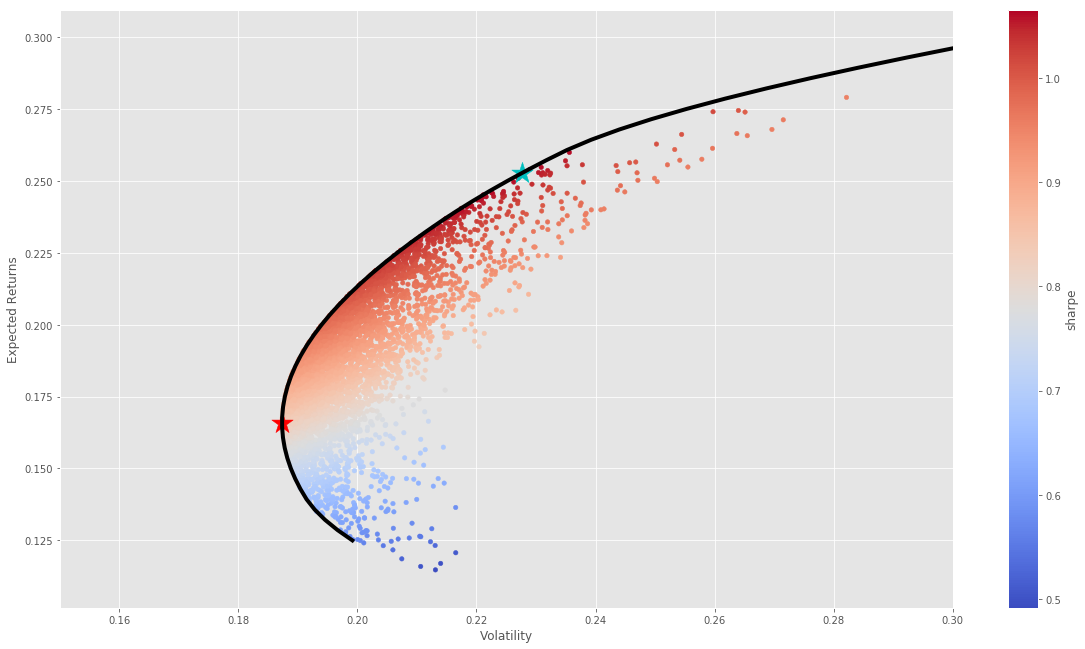

In [85]:
fig, ax = plt.subplots()
portfolio.plot(ax = ax, x = 'volatility', y = 'returns', kind = 'scatter', figsize = (20,11), c = 'sharpe', cmap = 'coolwarm')
#plt.scatter(portfolio[portfolio.volatility == portfolio.volatility.min()]['volatility'],portfolio[portfolio.volatility == portfolio.volatility.min()]['returns'], c = )
ax = plt.scatter(port_vol(optv['x']), port_ret(optv['x']), color = 'r', s = 500, marker = '*')
ax = plt.plot(tvols, trets, 'k', lw = 4)
ax = plt.scatter(port_vol(opts['x']), port_ret(opts['x']), color = 'c', s = 500, marker = '*')
plt.ylabel('Expected Returns')
plt.xlabel('Volatility')

plt.xlim([0.15,0.3])
plt.show()


In [86]:
import scipy.interpolate as sci

Now that we have found the points that make up the efficient frontier, we will use a spline approximation to find the f(x) that represents the frontier. By derivating this function at the point of maximum sharpe ratio, we will be able to find the second point necessary to plot the CML. 

In [87]:
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

In [88]:
tck = sci.splrep(evols, erets) #finds the spline approximation using the set of points evols and erts

In [90]:
def f(x): 
    ''' Efficient frontier function (splines approximation). 
    Parameters
    ========== 
    x: float - a number for which we want to calculate f(x)

    Returns
    =======
    the f(x) value where f(x) is the spline function 
    '''

    return sci.splev(x, tck, der = 0)

In [91]:
def df(x): 
    ''' First derivative of efficient frontier function. 
    Parameters
    ========== 
    x: float - a number for which we want to calculate df(x) the derivative of f(x)

    Returns
    =======
    the df(x) value where f(x) is the spline function '''
    return sci.splev(x, tck, der = 1)

In [111]:
def equations(p, rf = riskFreeReturn):
    '''
    Parameters
    ========== 
    p: list - starting estimates of the roots for the system of equations

    Returns
    =======
    system of equations '''

    eq1 = p[0] - rf
    eq2 = p[0] + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3 

In [112]:
opt = sco.fsolve(equations, [0.01,  optPort.loc['sharpe'], optPort.loc['volatility']]) # finds the roots of the system equations represented by equation. The roots allow to plot the CML line
opt

array([0.01      , 1.06657886, 0.23138124])

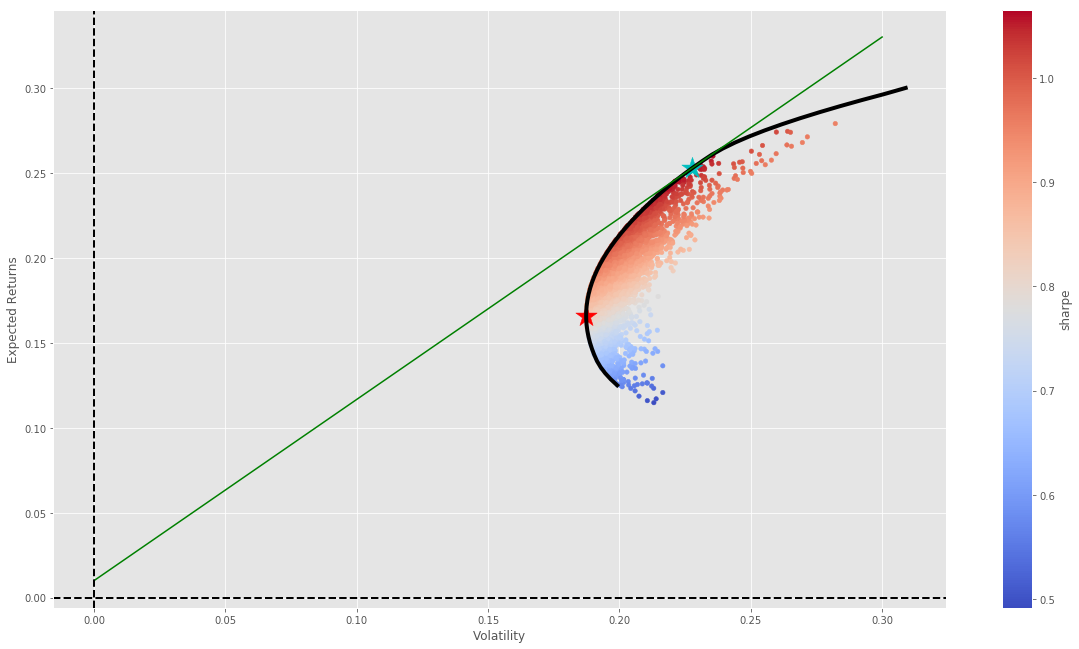

In [94]:
fig, ax = plt.subplots()
portfolio.plot(ax = ax, x = 'volatility', y = 'returns', kind = 'scatter', figsize = (20,11), c = 'sharpe', cmap = 'coolwarm')
#plt.scatter(portfolio[portfolio.volatility == portfolio.volatility.min()]['volatility'],portfolio[portfolio.volatility == portfolio.volatility.min()]['returns'], c = )
ax = plt.scatter(port_vol(optv['x']), port_ret(optv['x']), color = 'r', s = 500, marker = '*')
ax = plt.plot(tvols, trets, 'k', lw = 4)
ax = plt.scatter(port_vol(opts['x']), port_ret(opts['x']), color = 'c', s = 500, marker = '*')
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, 'g', lw = 1.5)
plt.axhline(0, color = 'k', ls = '--', lw = 2.0)
plt.axvline(0, color = 'k', ls = '--', lw = 2.0)
plt.ylabel('Expected Returns')
plt.xlabel('Volatility')

#plt.xlim([0.15,0.3])
plt.show()


In [95]:
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - f(opt[2])}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
res = sco.minimize(port_vol, eweights, method = 'SLSQP', bounds = bnds, constraints = cons)
res['x']

array([4.60735510e-01, 1.62659062e-02, 5.22998584e-01, 1.95156391e-18])